In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Setup paths for deployment
import os
from pathlib import Path

# Get the directory where this notebook is located
NOTEBOOK_DIR = Path.cwd()
print(f"Notebook directory: {NOTEBOOK_DIR}")

# Define data and model paths
DATA_FILE = NOTEBOOK_DIR / 'Train_Test_Network.csv'
MODELS_DIR = NOTEBOOK_DIR.parent / 'models'

# Create models directory if it doesn't exist
MODELS_DIR.mkdir(exist_ok=True)
print(f"Models directory: {MODELS_DIR}")

# Verify data file exists
if DATA_FILE.exists():
    print(f"✅ Data file found: {DATA_FILE}")
else:
    print(f"❌ Data file not found: {DATA_FILE}")
    print(f"Available CSV files: {list(NOTEBOOK_DIR.glob('*.csv'))}")

In [3]:

df = pd.read_csv(r"D:\SEP-2025\14Pro\CODE\1CIRA\CODE\train_test_network.c")  # Path to your datasetsv

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\SEP-2025\\14Pro\\CODE\\1CIRA\\CODE\\train_test_network.csv'

In [3]:

os.makedirs("models", exist_ok=True)

In [4]:
print("Shape of dataset:", df.shape)
print(" Columns:", df.columns.tolist())
print(" Missing values:\n", df.isnull().sum())

Shape of dataset: (2141, 8)
 Columns: ['tcp.srcport', 'tcp.dstport', 'tcp.len', 'http.content_length', 'tcp.seq', 'tcp.ack', 'tcp.raw_ack', 'attack_type']
 Missing values:
 tcp.srcport            0
tcp.dstport            0
tcp.len                0
http.content_length    0
tcp.seq                0
tcp.ack                0
tcp.raw_ack            0
attack_type            0
dtype: int64


In [5]:

attack_counts = df["attack_type"].value_counts()
print("\n Attack Type Distribution:\n", attack_counts)
attack_percent = (attack_counts / len(df) * 100).round(2).astype(str) + '%'
print("\n Attack Type % Distribution:\n", attack_percent)


 Attack Type Distribution:
 attack_type
Normal           856
DDoS_TCP         429
Password         428
Port_Scanning    428
Name: count, dtype: int64

 Attack Type % Distribution:
 attack_type
Normal           39.98%
DDoS_TCP         20.04%
Password         19.99%
Port_Scanning    19.99%
Name: count, dtype: object


In [6]:
# Mapping attack types to severity labels
mapping = {
    "Normal": "low",
    "DDoS_TCP": "medium",
    "Password": "high",
    "Port_Scanning": "very high"
}

# Add severity column
df['severity'] = df['attack_type'].map(mapping)

# Optional: make severity an ordered categorical
severity_order = ["low", "medium", "high", "very high"]
df['severity'] = pd.Categorical(df['severity'], categories=severity_order, ordered=True)

# Display attack_type distribution
attack_counts = df['attack_type'].value_counts()
attack_percent = (attack_counts / len(df) * 100).round(2).astype(str) + '%'
print("\nAttack Type Distribution:\n", attack_counts)
print("\nAttack Type % Distribution:\n", attack_percent)

# Display severity distribution
severity_counts = df['severity'].value_counts().reindex(severity_order)
severity_percent = (severity_counts / len(df) * 100).round(2).astype(str) + '%'
print("\nSeverity Distribution:\n", severity_counts)
print("\nSeverity % Distribution:\n", severity_percent)



Attack Type Distribution:
 attack_type
Normal           856
DDoS_TCP         429
Password         428
Port_Scanning    428
Name: count, dtype: int64

Attack Type % Distribution:
 attack_type
Normal           39.98%
DDoS_TCP         20.04%
Password         19.99%
Port_Scanning    19.99%
Name: count, dtype: object

Severity Distribution:
 severity
low          856
medium       429
high         428
very high    428
Name: count, dtype: int64

Severity % Distribution:
 severity
low          39.98%
medium       20.04%
high         19.99%
very high    19.99%
Name: count, dtype: object


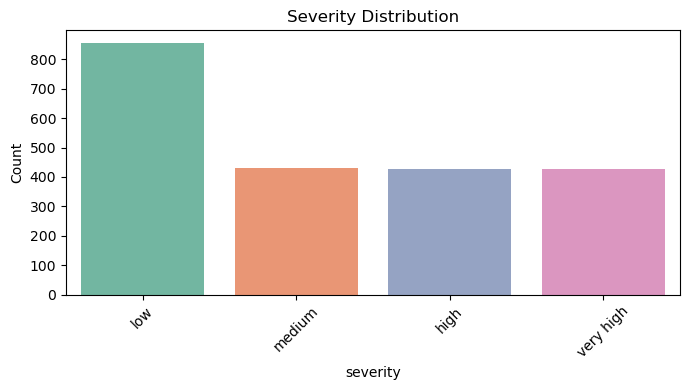

In [8]:
# Barplot of severity distribution
plt.figure(figsize=(7, 4))
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='Set2')
plt.title("Severity Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../models/severity_distribution.png")
plt.show()


In [9]:
# ==========  DUPLICATE & CONSTANT VALUE CHECK ==========
print(f"\n Duplicate Rows: {df.duplicated().sum()}")
constant_features = [col for col in df.columns if df[col].nunique() == 1]
print(f" Constant/Single-value columns: {constant_features}")


 Duplicate Rows: 2066
 Constant/Single-value columns: []


In [12]:
# ==========  FEATURE-TARGET CORRELATION ==========
le = LabelEncoder()
# Encode severity instead of attack_type
df['target_enc'] = le.fit_transform(df['severity'])
corr_with_target = df.drop(columns='severity').corr(numeric_only=True)['target_enc'].sort_values(ascending=False)
print("\nCorrelation with Target (Severity):\n", corr_with_target.head(10))



Correlation with Target (Severity):
 target_enc             1.000000
tcp.dstport            0.776083
tcp.srcport            0.594615
tcp.seq               -0.289925
tcp.raw_ack           -0.471739
http.content_length   -0.647954
tcp.ack               -0.709940
tcp.len               -0.730074
Name: target_enc, dtype: float64


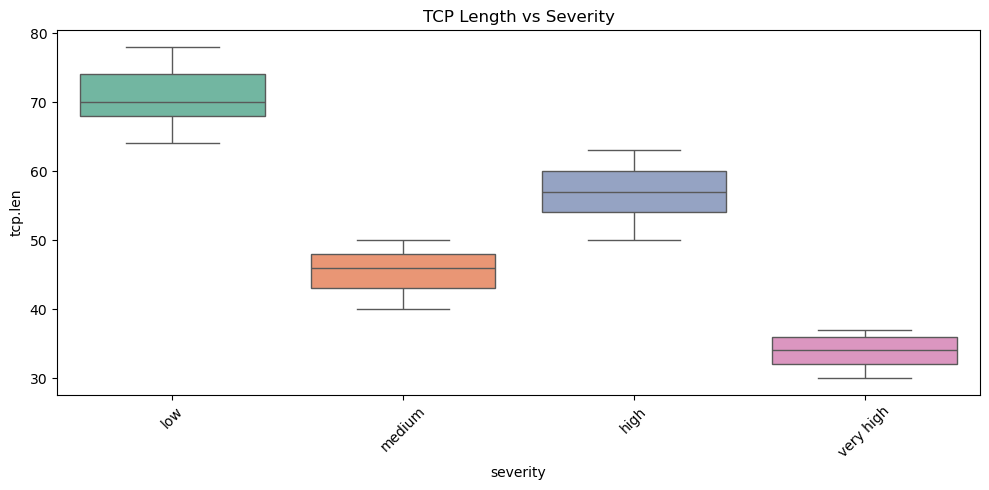

In [13]:

if 'tcp.len' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='severity', y='tcp.len', data=df, order=severity_order, palette='Set2')
    plt.title("TCP Length vs Severity")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("../models/boxplot_tcp_len_vs_severity.png")
    plt.show()


In [14]:

df.drop(columns=['target_enc'], inplace=True)
if constant_features:
    df.drop(columns=constant_features, inplace=True)


In [15]:

df = shuffle(df, random_state=42)

In [19]:
# Features and target using severity instead of attack_type
X = df.drop(columns=['attack_type', 'severity'])
y = df['severity']


In [20]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [21]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

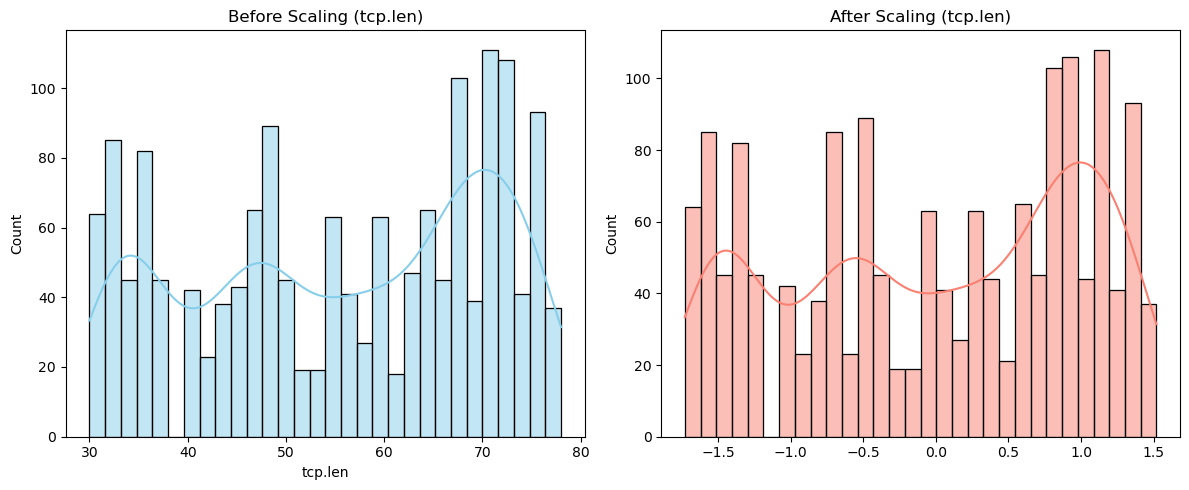

In [22]:
# ========== BEFORE/AFTER SCALING ==========
if 'tcp.len' in X.columns:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(X_train['tcp.len'], kde=True, bins=30, color='skyblue')
    plt.title("Before Scaling (tcp.len)")

    plt.subplot(1, 2, 2)
    sns.histplot(X_train_scaled[:, X.columns.get_loc('tcp.len')], kde=True, bins=30, color='salmon')
    plt.title("After Scaling (tcp.len)")

    plt.tight_layout()
    plt.savefig("../models/scaling_comparison.png")
    plt.show()

In [23]:
# ==========  DUMMY BASELINE ==========
dummy = DummyClassifier(strategy='most_frequent').fit(X_train_scaled, y_train)
dummy_acc = accuracy_score(y_test, dummy.predict(X_test_scaled))
print(f"\n Dummy Classifier Accuracy (Baseline): {dummy_acc*100:.2f}%")


 Dummy Classifier Accuracy (Baseline): 39.93%


In [24]:
# ==========  MODEL TRAINING ==========
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [25]:
# ==========  METRICS ==========
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f" Model Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")


 Classification Report:
               precision    recall  f1-score   support

        high       1.00      1.00      1.00       107
         low       1.00      1.00      1.00       214
      medium       1.00      1.00      1.00       108
   very high       1.00      1.00      1.00       107

    accuracy                           1.00       536
   macro avg       1.00      1.00      1.00       536
weighted avg       1.00      1.00      1.00       536

 Confusion Matrix:
 [[107   0   0   0]
 [  0 214   0   0]
 [  0   0 108   0]
 [  0   0   0 107]]
 Model Accuracy: 100.00%


In [26]:
# ==========  FEATURE IMPORTANCE ==========
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

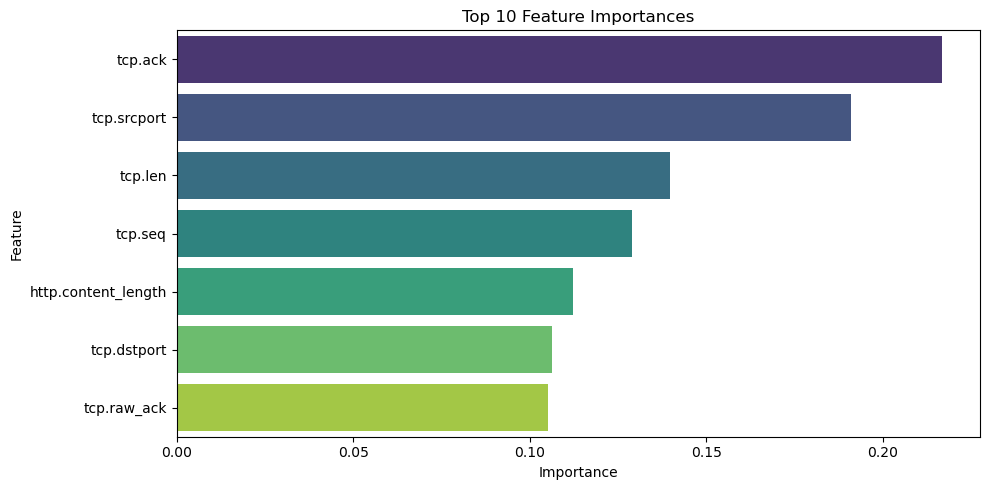

In [27]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.savefig("../models/feature_importance.png")
plt.show()

In [28]:
import seaborn as sns
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, auc
)
from itertools import cycle
from IPython.display import display

In [29]:
plt.style.use("ggplot")
os.makedirs('../models/graphs', exist_ok=True)

In [33]:
#  Load Dataset
df = pd.read_csv('Train_Test_Network.csv')
df.columns = df.columns.str.strip().str.lower()

In [34]:
# Show first 10 rows
print("\nDataset Preview (first 10 rows):")
print(df.head(10).to_string(index=False))


Dataset Preview (first 10 rows):
 tcp.srcport  tcp.dstport  tcp.len  http.content_length  tcp.seq  tcp.ack  tcp.raw_ack   attack_type
       52345           80       45                    0     1020      150         1020      DDoS_TCP
          80          443       68                  120      750     1800          900        Normal
        9001           22       55                   80      600     1100          700      Password
       20000        25000       30                    0      300       50          300 Port_Scanning
          80          443       72                  180      800     1900          950        Normal
       15000           80       40                    0      980      120          980      DDoS_TCP
          80          443       65                  110      720     1750          880        Normal
        9002           21       50                   70      580     1050          680      Password
       21000        26000       32                    0  

In [37]:
# Mapping attack types to severity labels
mapping = {
    "Normal": "low",
    "DDoS_TCP": "medium",
    "Password": "high",
    "Port_Scanning": "very high"
}

# Add severity column
df['severity'] = df['attack_type'].map(mapping)

# Define severity order
severity_order = ["low", "medium", "high", "very high"]

# Show Severity Distribution
severity_counts = df['severity'].value_counts().reindex(severity_order)
severity_percent = (severity_counts / len(df) * 100).round(2)

print("\nSeverity Distribution (Count Table):")
print(severity_counts.to_string())

print("\nSeverity Distribution (Percentage):")
print((severity_percent.astype(str) + "%").to_string())



Severity Distribution (Count Table):
severity
low          856
medium       429
high         428
very high    428

Severity Distribution (Percentage):
severity
low          39.98%
medium       20.04%
high         19.99%
very high    19.99%


In [38]:
# Save attack distribution
attack_counts.to_csv("../models/attack_type_counts.csv", header=["Count"])

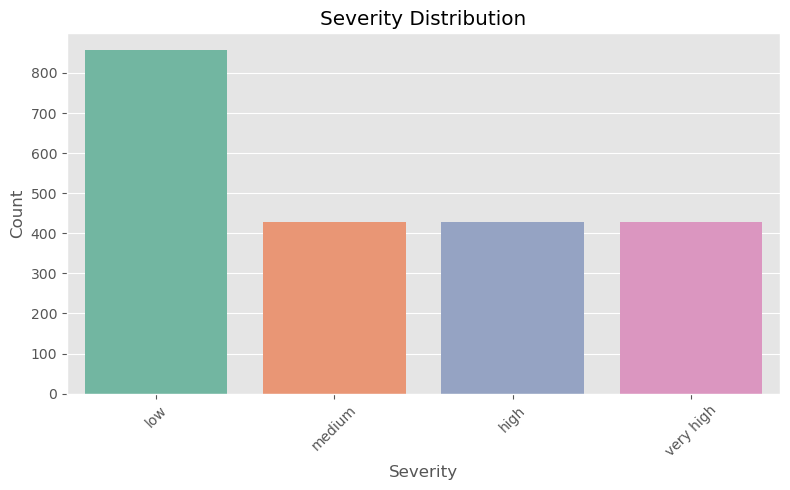

In [41]:
#  Enhanced Distribution Barplot by Severity
plt.figure(figsize=(8, 5))
sns.barplot(x=severity_counts.index, y=severity_counts.values,
            hue=severity_counts.index, palette="Set2",
            dodge=False, legend=False)
plt.title("Severity Distribution")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../models/graphs/severity_distribution.png")
plt.show()


In [42]:
#  Features and Labels
features = [
    'tcp.srcport', 'tcp.dstport', 'tcp.len',
    'http.content_length', 'tcp.seq', 'tcp.ack', 'tcp.raw_ack'
]
label_col = 'attack_type'
df = df[features + [label_col]].dropna()

X = df[features]
y = df[label_col]
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y)
n_classes = len(lb.classes_)

In [43]:
#  Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
_, _, y_train_bin, y_test_bin = train_test_split(
    X, y_binarized, test_size=0.2, random_state=42, stratify=y
)

In [44]:
#  Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

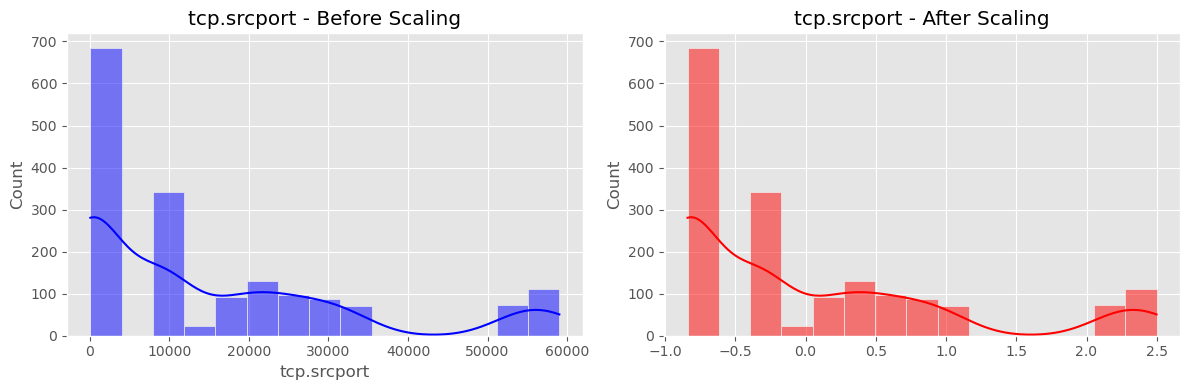

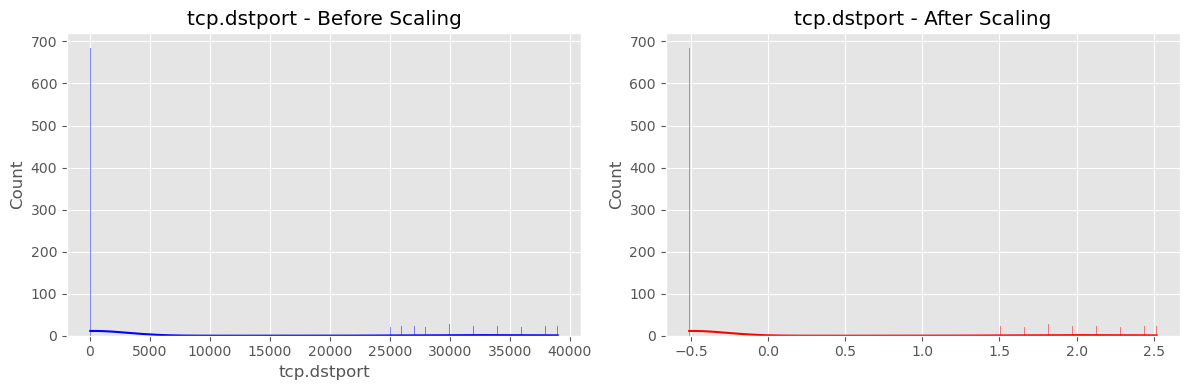

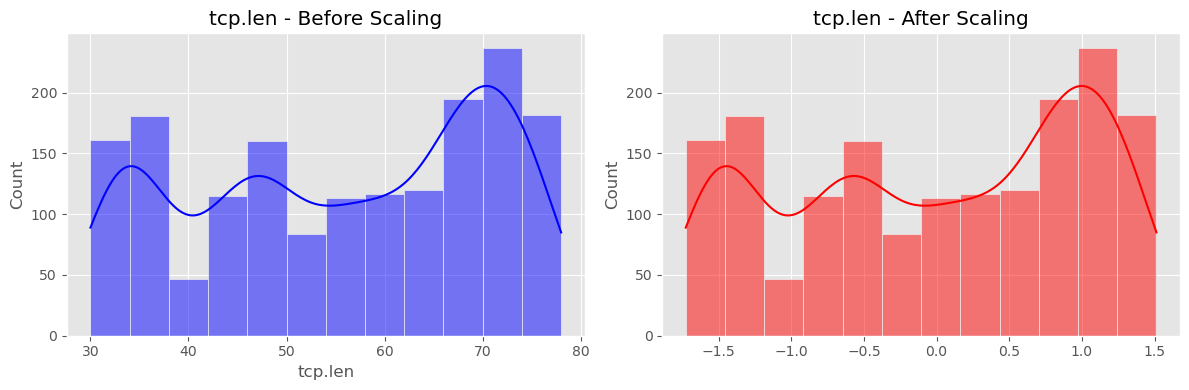

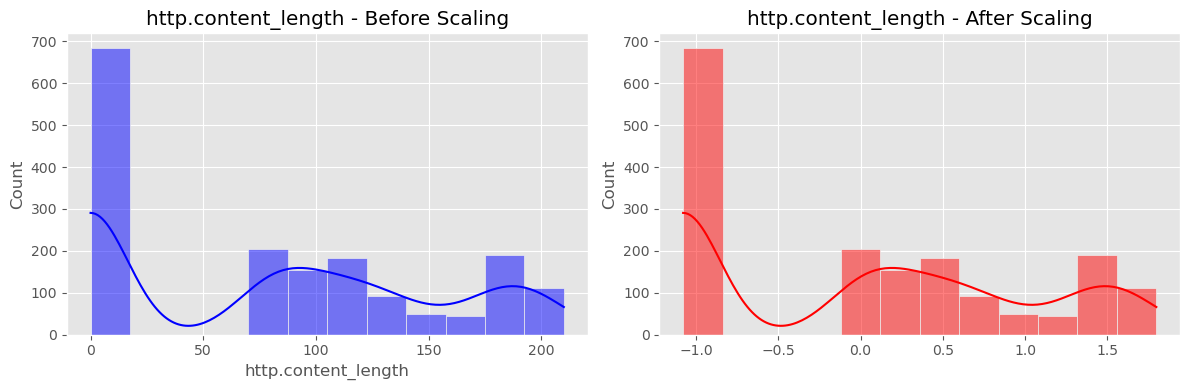

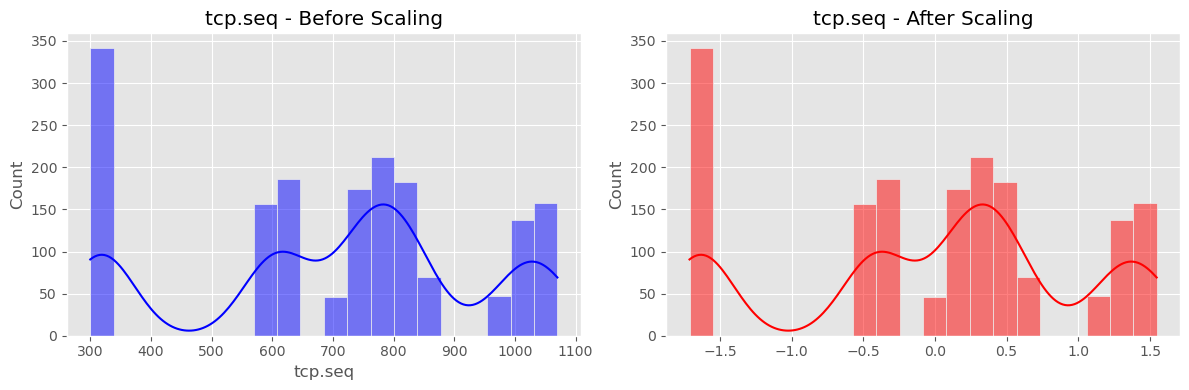

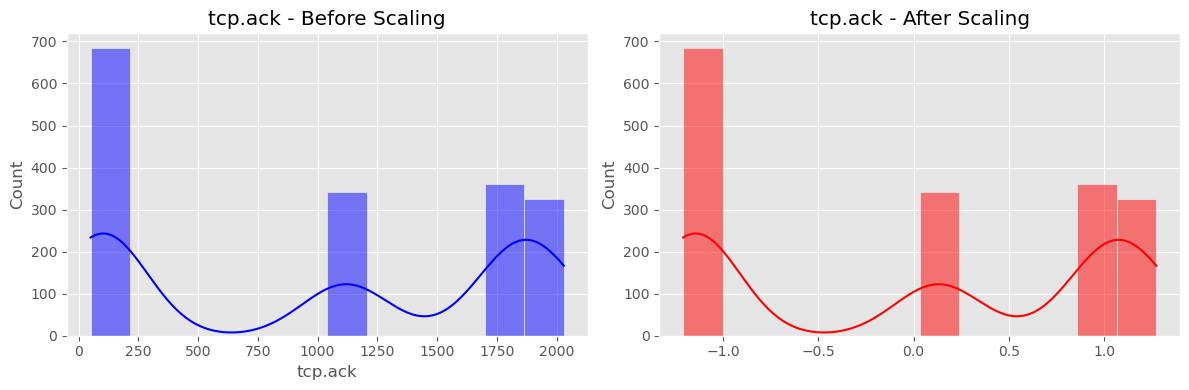

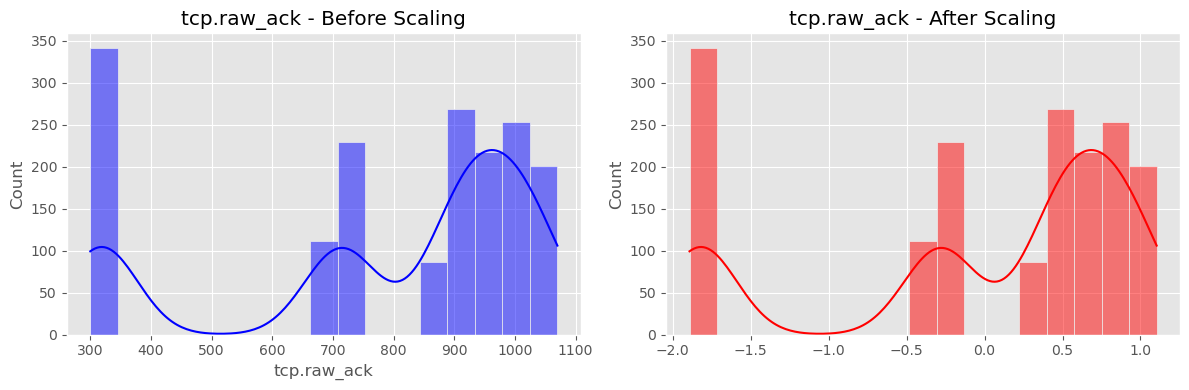

✅ Saved all feature distribution plots before and after scaling.


In [45]:
#  Before and After Scaling Graphs
for feature in features:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(X_train[feature], kde=True, color='blue')
    plt.title(f'{feature} - Before Scaling')

    plt.subplot(1, 2, 2)
    index = features.index(feature)
    sns.histplot(X_train_scaled[:, index], kde=True, color='red')
    plt.title(f'{feature} - After Scaling')

    plt.tight_layout()
    plt.savefig(f"../models/graphs/feature_{feature}_scaling.png")
    plt.show()
    plt.close()

print("✅ Saved all feature distribution plots before and after scaling.")

In [46]:
#  Define Models
models = {
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'decision_tree': DecisionTreeClassifier(random_state=42),
    'gradient_boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'logistic_regression': LogisticRegression(max_iter=1000, random_state=42),
    'svm': SVC(probability=True, random_state=42),
    'k_neighbors': KNeighborsClassifier(n_neighbors=5),
    'extra_trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'mlp': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, activation='relu', solver='adam', random_state=42)
}
accuracy_scores = {}
summary_rows = []

In [52]:
# Map attack_type → severity
mapping = {
    "Normal": "low",
    "DDoS_TCP": "medium",
    "Password": "high",
    "Port_Scanning": "very high"
}
df['severity'] = df['attack_type'].map(mapping)


In [54]:
X = df.drop(columns=['attack_type', 'severity'])
y = df['severity']


In [56]:
# 1. Map attack_type → severity
mapping = {
    "Normal": "low",
    "DDoS_TCP": "medium",
    "Password": "high",
    "Port_Scanning": "very high"
}
df['severity'] = df['attack_type'].map(mapping)

# 2. Define features & target
X = df.drop(columns=['attack_type', 'severity'])
y = df['severity']

# 3. Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Fit LabelBinarizer on severity (not attack_type)
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)   # 👈 severity labels
y_test_bin = lb.transform(y_test)

n_classes = len(lb.classes_)
print("Classes:", lb.classes_)


Classes: ['high' 'low' 'medium' 'very high']



 Training Random_Forest...
 Accuracy: 100.00%


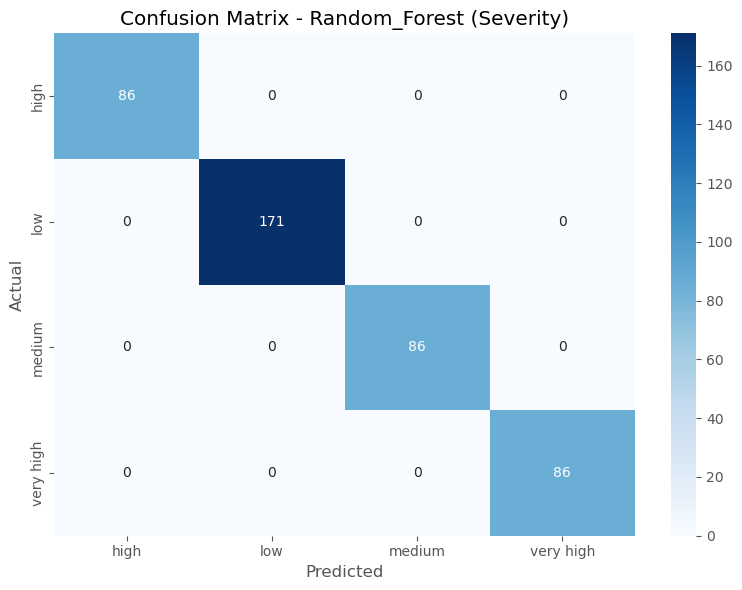

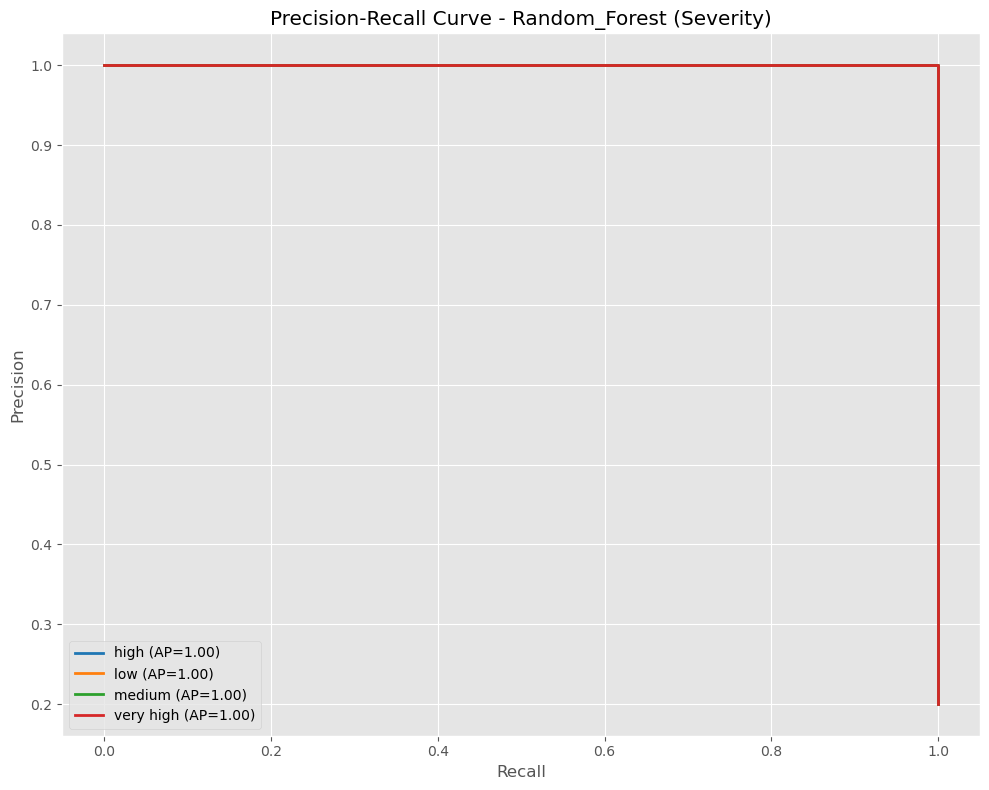


 Training Decision_Tree...
 Accuracy: 100.00%


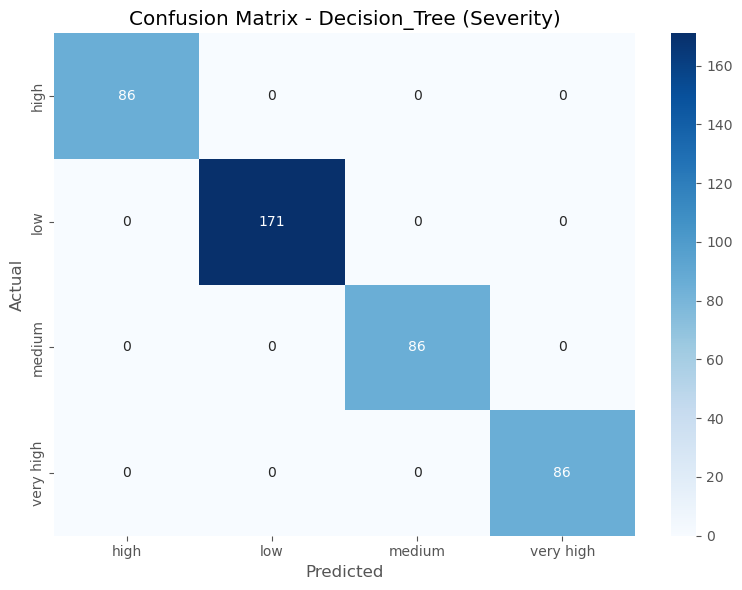

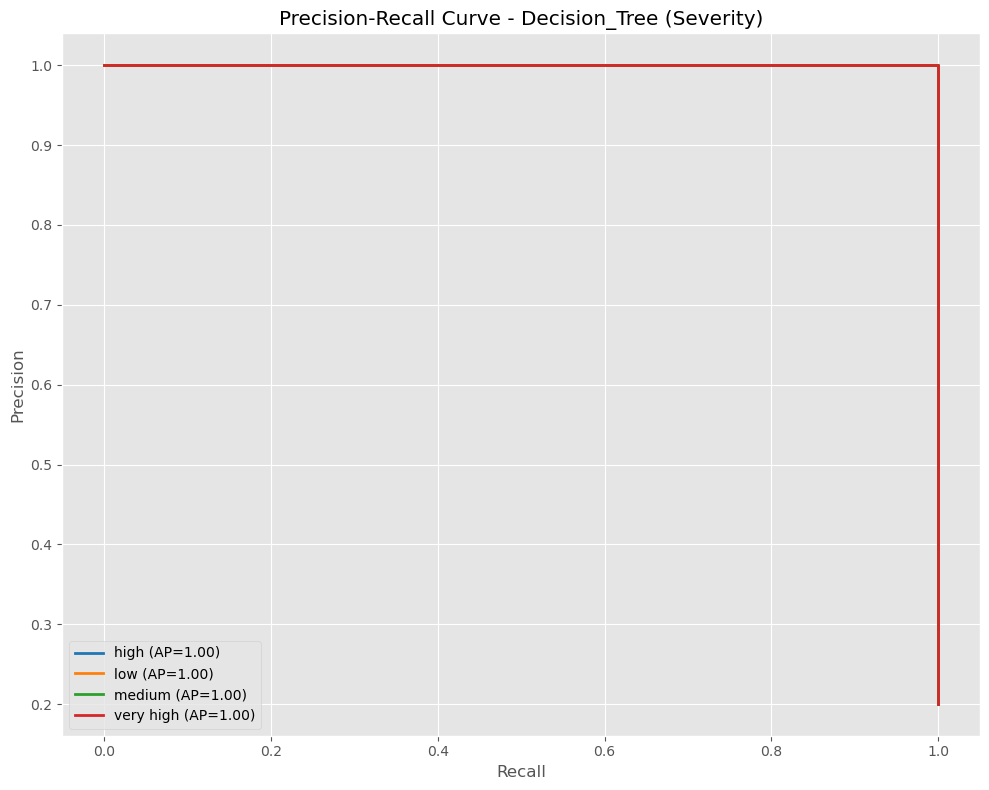


 Training Gradient_Boosting...
 Accuracy: 100.00%


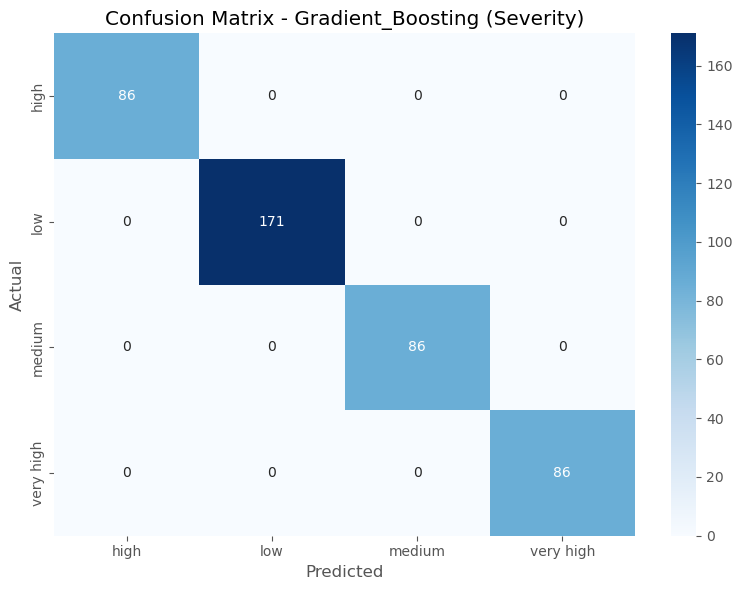

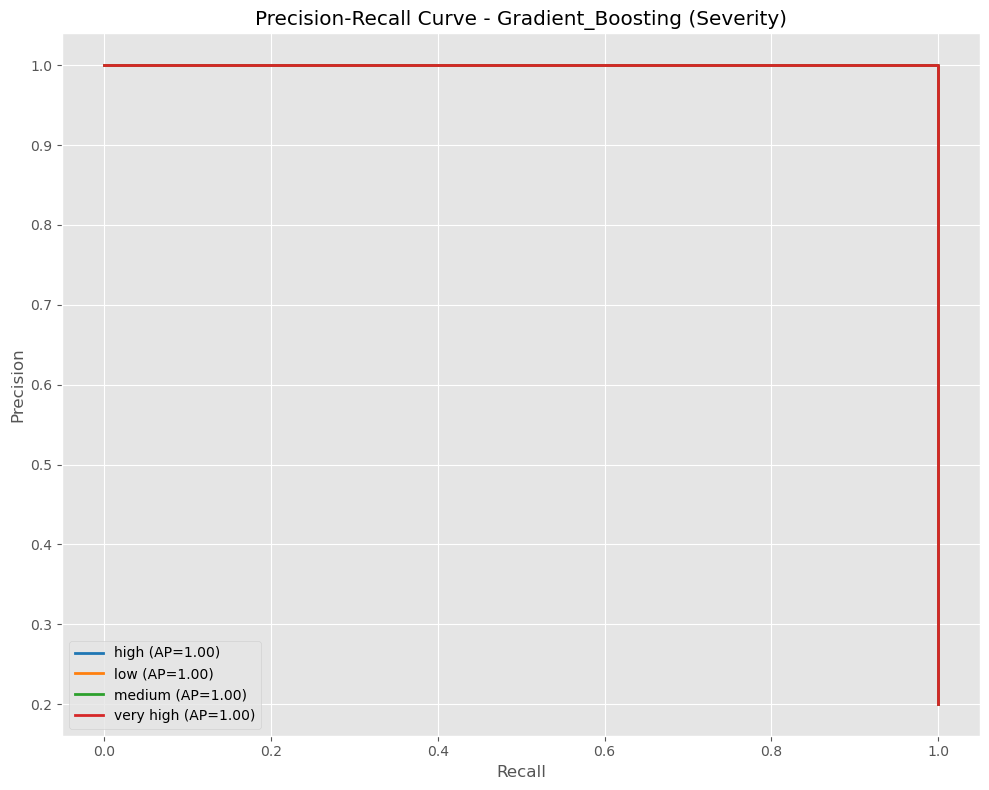


 Training Logistic_Regression...
 Accuracy: 100.00%


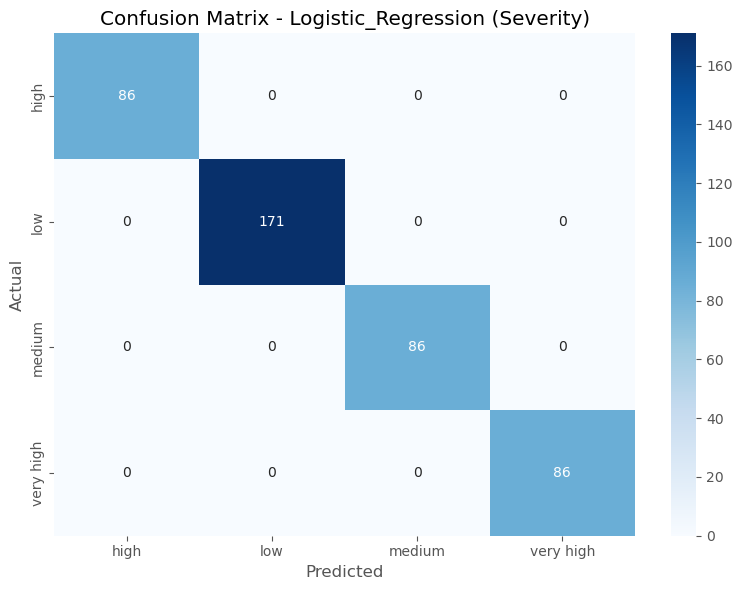

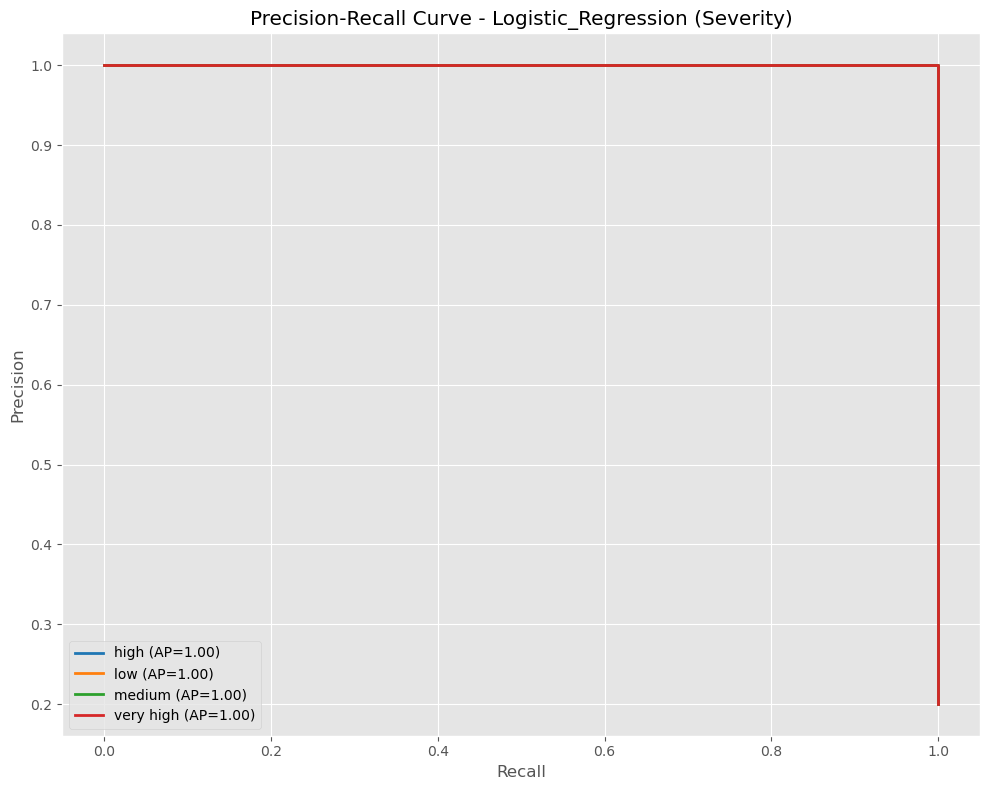


 Training Svm...
 Accuracy: 100.00%


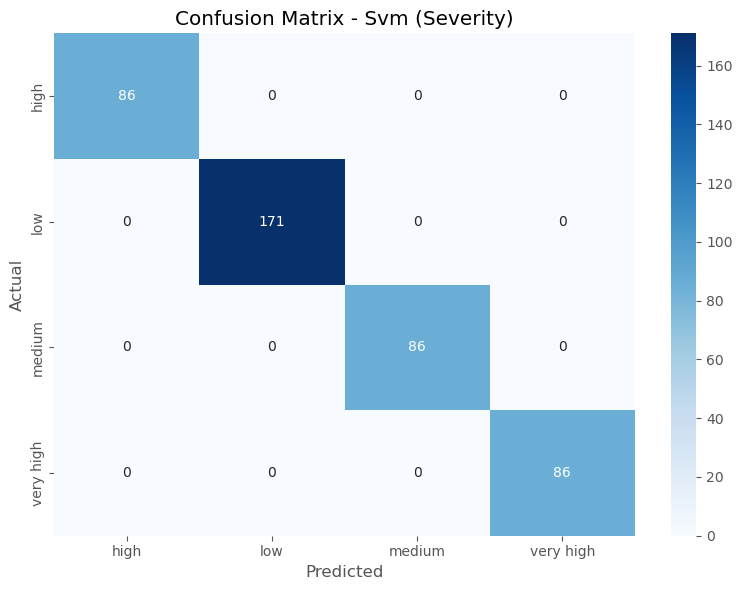

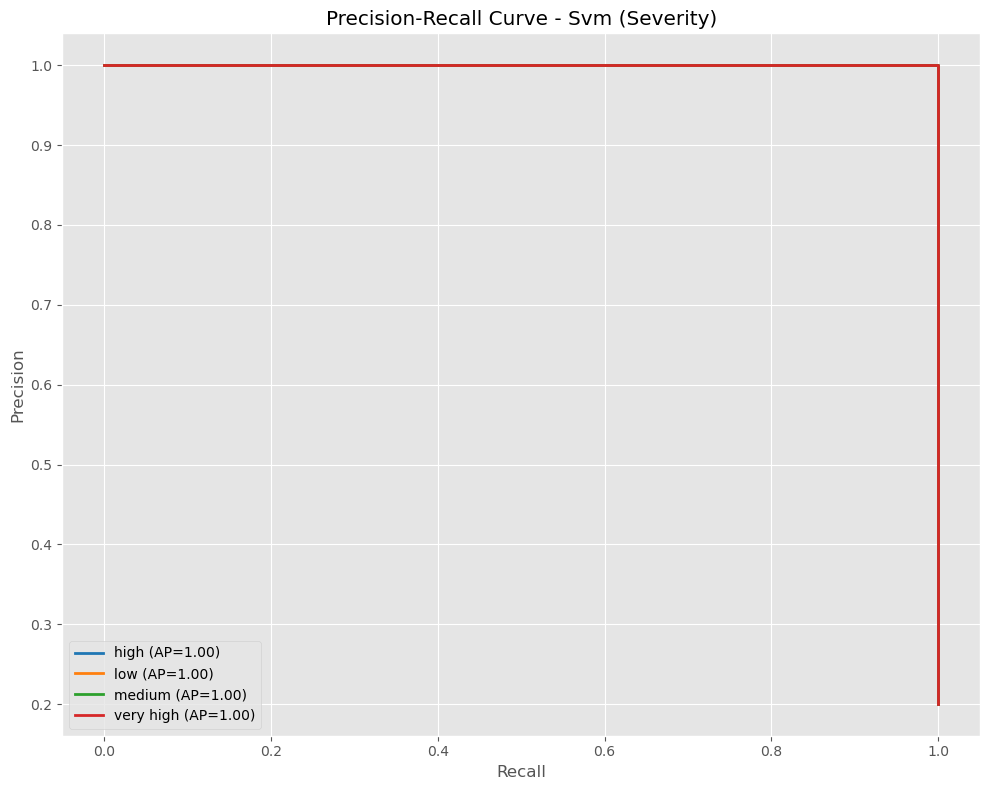


 Training K_Neighbors...
 Accuracy: 100.00%


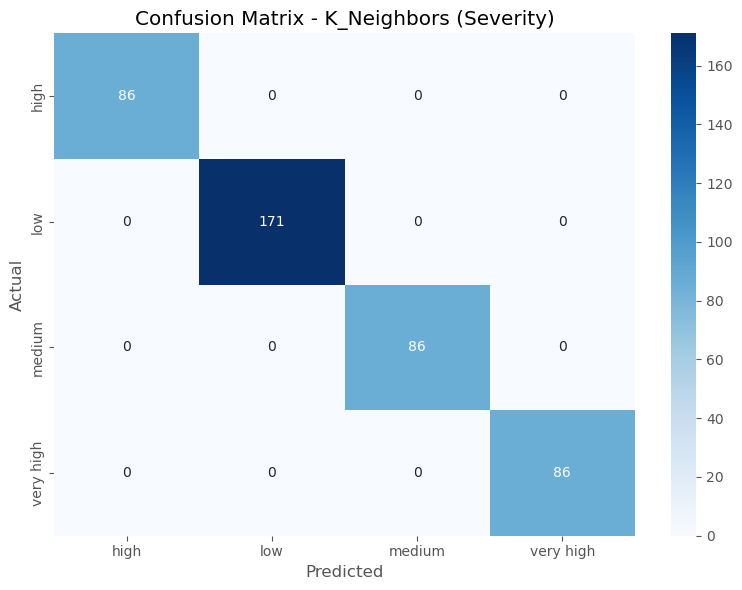

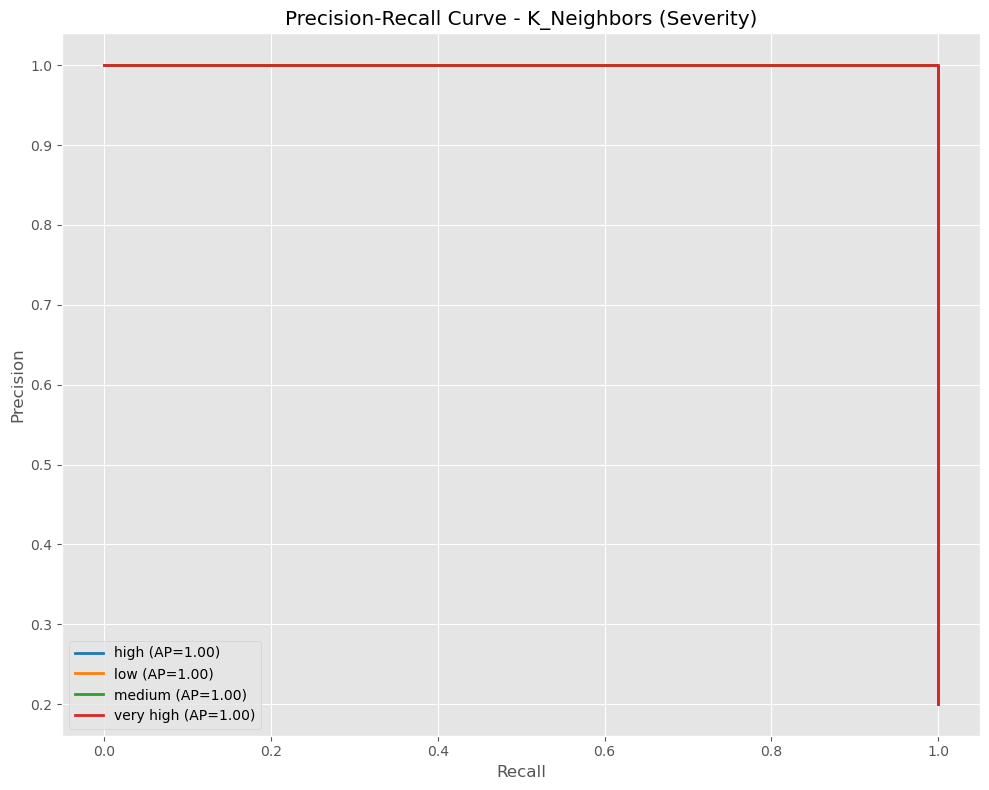


 Training Extra_Trees...
 Accuracy: 100.00%


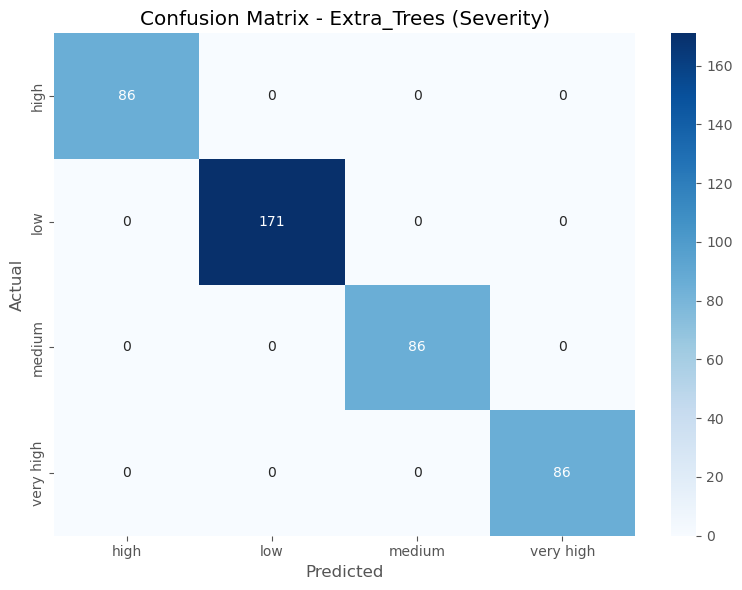

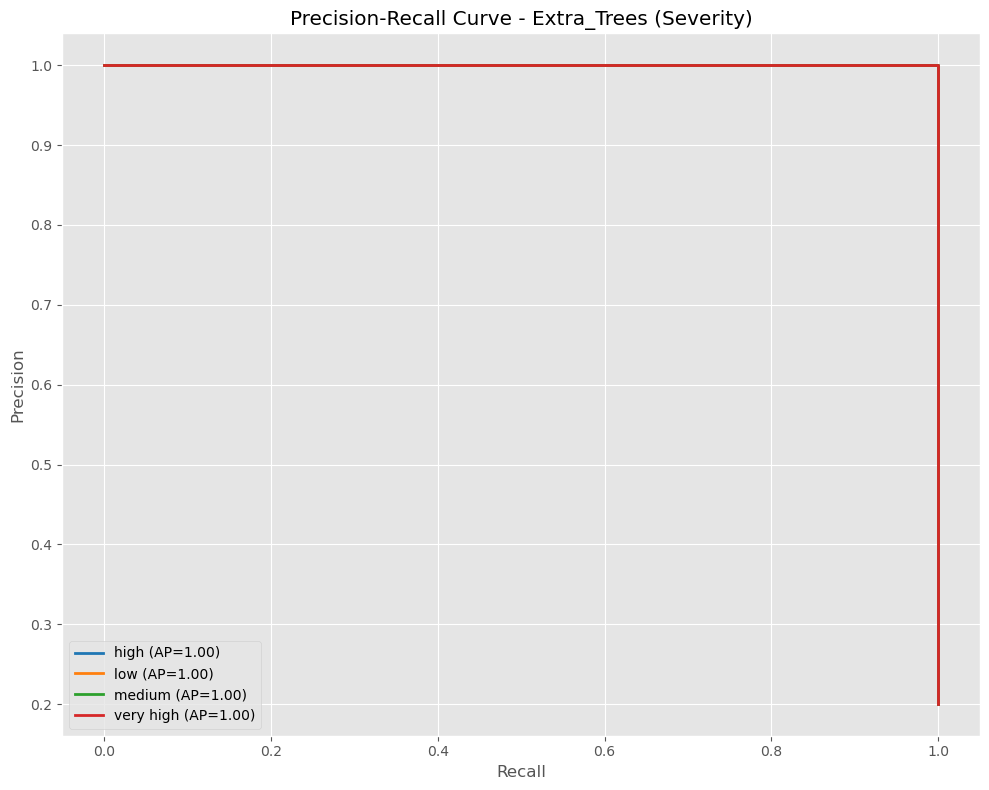


 Training Mlp...
 Accuracy: 100.00%


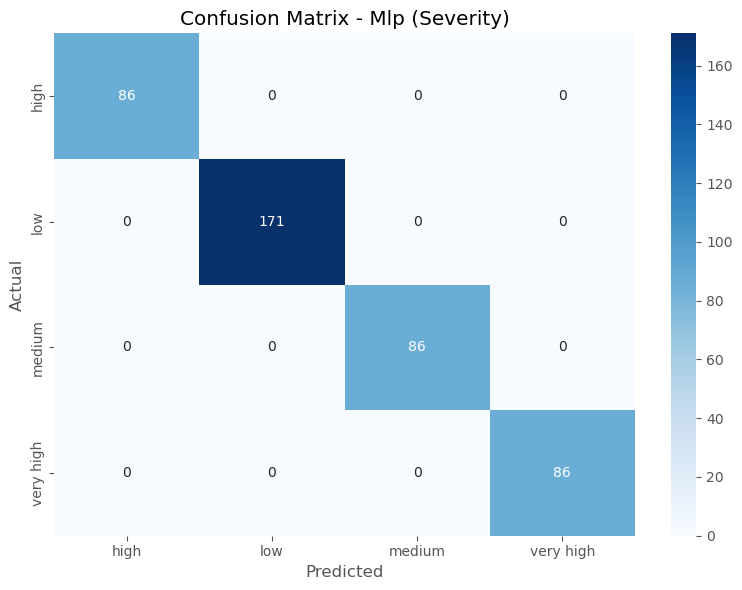

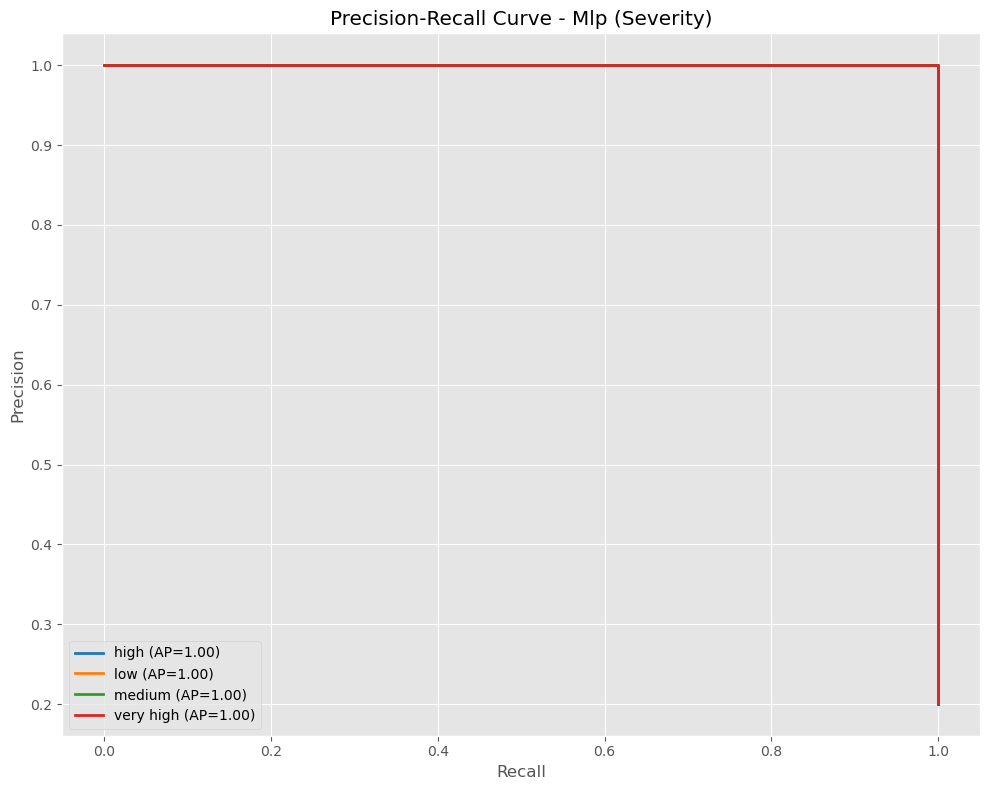

In [57]:
import joblib

#  Train + Evaluate Each Model
for name, model in models.items():
    print(f"\n Training {name.title()}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = round(accuracy * 100, 2)

    print(f" Accuracy: {accuracy_scores[name]:.2f}%")
    report = classification_report(y_test, y_pred, target_names=lb.classes_, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    #  Confusion Matrix Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=lb.classes_, yticklabels=lb.classes_)
    plt.title(f'Confusion Matrix - {name.title()} (Severity)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f"../models/graphs/{name}_conf_matrix_severity.png")
    plt.show()

    # PR Curve (if possible)
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test_scaled)
        plt.figure(figsize=(10, 8))
        colors = cycle(plt.cm.tab10.colors)
        for i, color in zip(range(n_classes), colors):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            ap = auc(recall, precision)
            plt.plot(recall, precision, lw=2, color=color,
                     label=f'{lb.classes_[i]} (AP={ap:.2f})')

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f'Precision-Recall Curve - {name.title()} (Severity)')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"../models/graphs/{name}_pr_curve_severity.png")
        plt.show()
    else:
        print("Skipping PR Curve (no predict_proba).")

    #  Save Model Files
    joblib.dump(model, f'../models/{name}_severity_model.joblib')
    joblib.dump(scaler, f'../models/{name}_severity_scaler.joblib')
    joblib.dump(features, f'../models/{name}_severity_features.joblib')
    joblib.dump(lb, f'../models/{name}_severity_label_binarizer.joblib')

    #  Collect Summary
    summary_row = {'model': name, 'accuracy': accuracy_scores[name]}
    for cls in lb.classes_:
        summary_row[f'{cls}_precision'] = report[cls]['precision']
        summary_row[f'{cls}_recall'] = report[cls]['recall']
        summary_row[f'{cls}_f1'] = report[cls]['f1-score']
    summary_rows.append(summary_row)


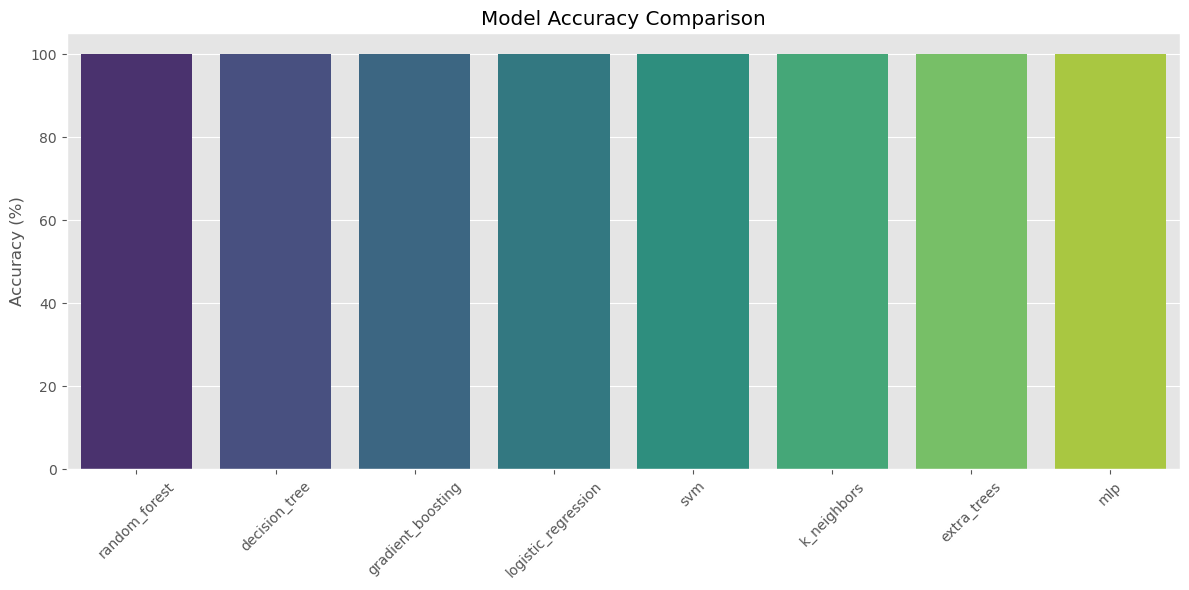

In [58]:
#  Accuracy Comparison Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../models/graphs/accuracy_comparison.png')
plt.show()

In [59]:
#🧾 Save Model Summary Table
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("../models/report_summary.csv", index=False)
print("\n Summary report saved as models/report_summary.csv")
print(" All training, evaluation, and visualizations completed successfully!")


 Summary report saved as models/report_summary.csv
 All training, evaluation, and visualizations completed successfully!


In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import flwr as fl
import xgboost as xgb
from sklearn.svm import SVC


In [7]:
# Example dataset (replace with your path)
data_path = "Train_Test_Network.csv"

df = pd.read_csv(data_path)

# Map attack types → severity
mapping = {
    "Normal": "low",
    "DDoS_TCP": "medium",
    "Password": "high",
    "Port_Scanning": "very high"
}
df['severity'] = df['attack_type'].map(mapping)

# Encode target
le = LabelEncoder()
df['target'] = le.fit_transform(df['severity'])

# Features
X = df.drop(columns=['attack_type', 'severity', 'target'])
y = df['target']

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Classes:", le.classes_)
print("X shape:", X.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'D:/SEP-2025/14Pro/CODE/1CIRA/CODE/train_test_network.csv'

In [67]:
class SVMClient(fl.client.NumPyClient):
    def __init__(self, X, y, cid="0"):
        self.X, self.y = X, y
        self.model = SVC(kernel="linear", probability=True, random_state=42)
        self.cid = cid

    def get_parameters(self, config=None):
        # Linear SVM exposes coef_/intercept_
        if hasattr(self.model, "coef_"):
            return [self.model.coef_, self.model.intercept_]
        else:
            return []

    def fit(self, parameters, config=None):
        self.model.fit(self.X, self.y)
        preds = self.model.predict(self.X)
        acc = accuracy_score(self.y, preds)
        return self.get_parameters(), len(self.X), {"accuracy": acc}

    def evaluate(self, parameters, config=None):
        preds = self.model.predict(self.X)
        acc = accuracy_score(self.y, preds)
        return float(acc), len(self.X), {"accuracy": float(acc)}


In [68]:
class XGBClient(fl.client.NumPyClient):
    def __init__(self, X, y, cid="0"):
        self.X, self.y = X, y
        self.dtrain = xgb.DMatrix(X, label=y)
        self.params = {"objective": "multi:softprob", "num_class": len(np.unique(y)), "max_depth": 4}
        self.bst = None
        self.cid = cid

    def get_parameters(self, config=None):
        return []  # handled internally in XGB

    def fit(self, parameters, config=None):
        self.bst = xgb.train(self.params, self.dtrain, num_boost_round=10)
        preds = np.argmax(self.bst.predict(self.dtrain), axis=1)
        acc = accuracy_score(self.y, preds)
        return [], len(self.X), {"accuracy": acc}

    def evaluate(self, parameters, config=None):
        preds = np.argmax(self.bst.predict(self.dtrain), axis=1)
        acc = accuracy_score(self.y, preds)
        return float(acc), len(self.X), {"accuracy": float(acc)}


In [73]:
import flwr as fl
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split


In [74]:
# Load iris dataset
X, y = load_iris(return_X_y=True)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [75]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self):
        self.model = LogisticRegression(max_iter=100)

    def get_parameters(self, config=None):
        return [self.model.coef_, self.model.intercept_]

    def set_parameters(self, parameters):
        self.model.coef_ = parameters[0]
        self.model.intercept_ = parameters[1]

    def fit(self, parameters, config=None):
        if parameters:
            self.set_parameters(parameters)
        self.model.fit(X_train, y_train)
        preds = self.model.predict(X_train)
        acc = accuracy_score(y_train, preds)
        return self.get_parameters(), len(X_train), {"train_accuracy": acc}

    def evaluate(self, parameters, config=None):
        if parameters:
            self.set_parameters(parameters)
        preds = self.model.predict(X_test)
        loss = log_loss(y_test, self.model.predict_proba(X_test))
        acc = accuracy_score(y_test, preds)
        return float(loss), len(X_test), {"val_accuracy": acc}


In [77]:
import numpy as np

class FlowerClient(fl.client.NumPyClient):
    def __init__(self):
        self.model = LogisticRegression(max_iter=100)
        # initialize dummy parameters (3 classes x 4 features for iris)
        # adapt size to your dataset
        self.n_features = 4
        self.n_classes = 3
        self.model.coef_ = np.zeros((self.n_classes, self.n_features))
        self.model.intercept_ = np.zeros(self.n_classes)

    def get_parameters(self, config=None):
        return [self.model.coef_, self.model.intercept_]

    def set_parameters(self, parameters):
        self.model.coef_ = parameters[0]
        self.model.intercept_ = parameters[1]

    def fit(self, parameters, config=None):
        if parameters:
            self.set_parameters(parameters)
        self.model.fit(X_train, y_train)
        preds = self.model.predict(X_train)
        acc = accuracy_score(y_train, preds)
        return self.get_parameters(), len(X_train), {"train_accuracy": acc}

    def evaluate(self, parameters, config=None):
        if parameters:
            self.set_parameters(parameters)
        preds = self.model.predict(X_test)
        loss = log_loss(y_test, self.model.predict_proba(X_test))
        acc = accuracy_score(y_test, preds)
        return float(loss), len(X_test), {"val_accuracy": acc}


In [81]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, classification_report
import flwr as fl

# Example datasets
# X_train, X_test, y_train, y_test = ...

# Store metrics globally for inspection
train_metrics_history = []
test_metrics_history = []

class FlowerClient(fl.client.NumPyClient):
    def __init__(self):
        self.model = LogisticRegression(max_iter=100)
        n_features = X_train.shape[1]
        n_classes = len(np.unique(y_train))
        self.model.coef_ = np.zeros((n_classes, n_features))
        self.model.intercept_ = np.zeros(n_classes)
        self.model.classes_ = np.unique(y_train)

    def get_parameters(self, config=None):
        return [self.model.coef_, self.model.intercept_]

    def set_parameters(self, parameters):
        self.model.coef_ = parameters[0]
        self.model.intercept_ = parameters[1]

    def fit(self, parameters, config=None):
        if parameters:
            self.set_parameters(parameters)
        self.model.fit(X_train, y_train)

        # Train metrics
        preds_train = self.model.predict(X_train)
        proba_train = self.model.predict_proba(X_train)
        loss_train = log_loss(y_train, proba_train)
        acc_train = accuracy_score(y_train, preds_train)
        report_train = classification_report(y_train, preds_train, output_dict=True)

        train_metrics_history.append({
            "loss": float(loss_train),
            "accuracy": float(acc_train),
            "classification_report": report_train  # keep locally, not returned to Flower
        })

        return self.get_parameters(), len(X_train), {}  # metrics dict must be simple types

    def evaluate(self, parameters, config=None):
        if parameters:
            self.set_parameters(parameters)
        preds_test = self.model.predict(X_test)
        loss_test = log_loss(y_test, self.model.predict_proba(X_test))
        acc_test = accuracy_score(y_test, preds_test)
        report_test = classification_report(y_test, preds_test, output_dict=True)

        test_metrics_history.append({
            "loss": float(loss_test),
            "accuracy": float(acc_test),
            "classification_report": report_test
        })

        # Only return float/int metrics to Flower
        return float(loss_test), len(X_test), {"accuracy": float(acc_test)}


# Run federated simulation
def client_fn(cid: str):
    return FlowerClient()

hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=3),
    ray_init_args={"local_mode": True},
)

# Inspect metrics after simulation
for i, metrics in enumerate(train_metrics_history, 1):
    print(f"\nRound {i} - Train Accuracy: {metrics['accuracy']:.4f}, Train Loss: {metrics['loss']:.4f}")
for i, metrics in enumerate(test_metrics_history, 1):
    print(f"\nRound {i} - Test Accuracy: {metrics['accuracy']:.4f}, Test Loss: {metrics['loss']:.4f}")


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
C:\Users\follo\AppData\Roaming\Python\Python312\site-packages\ray\_private\client_mode_hook.py:103: DeprecationWarning: DeprecationWarning: local mode is an experimental feature that is no longer maintained and will be removed in the future.For debugging consider using Ray debugger. 
  return func(*args, **kwargs)
2025-09-23 13:35:58,588	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 1207082190.0, 'object_store_memory': 603541094.0, 'CPU': 12.0, 'no

:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor
:actor_name:ClientAppActor


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        

            This is a deprecated feature. It will be removed
            entirely in future 

In [83]:
# Inspect metrics after simulation
for i, metrics in enumerate(train_metrics_history, 1):
    print(f"\nRound {i} - Train Accuracy: {metrics['accuracy']:.4f}, Train Loss: {metrics['loss']:.4f}")
    print("Training Classification Report:")
    # Print nicely
    for label, stats in metrics['classification_report'].items():
        if label not in ["accuracy", "macro avg", "weighted avg"]:
            print(f"  Class {label}: Precision: {stats['precision']:.4f}, Recall: {stats['recall']:.4f}, F1-score: {stats['f1-score']:.4f}, Support: {int(stats['support'])}")
    print(f"  Overall Accuracy: {metrics['classification_report']['accuracy']:.4f}")

for i, metrics in enumerate(test_metrics_history, 1):
    print(f"\nRound {i} - Test Accuracy: {metrics['accuracy']:.4f}, Test Loss: {metrics['loss']:.4f}")
    print("Testing Classification Report:")
    for label, stats in metrics['classification_report'].items():
        if label not in ["accuracy", "macro avg", "weighted avg"]:
            print(f"  Class {label}: Precision: {stats['precision']:.4f}, Recall: {stats['recall']:.4f}, F1-score: {stats['f1-score']:.4f}, Support: {int(stats['support'])}")
    print(f"  Overall Accuracy: {metrics['classification_report']['accuracy']:.4f}")


In [85]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, classification_report

# Example datasets
# X_train, X_test, y_train, y_test = ...

# Simulate clients by splitting training data
num_clients = 3
client_data = np.array_split(np.c_[X_train, y_train], num_clients)  # split columns
client_test_data = [(X_test, y_test)] * num_clients  # same test for all

# Store metrics
train_metrics_history = []
test_metrics_history = []

num_rounds = 3
for rnd in range(1, num_rounds + 1):
    print(f"\n=== Round {rnd} ===")
    # Local client updates
    client_models = []
    for client_idx, data in enumerate(client_data):
        X_c, y_c = data[:, :-1], data[:, -1]
        model = LogisticRegression(max_iter=100)
        model.fit(X_c, y_c)
        client_models.append(model)

        # Train metrics
        y_pred_train = model.predict(X_c)
        y_proba_train = model.predict_proba(X_c)
        train_loss = log_loss(y_c, y_proba_train)
        train_acc = accuracy_score(y_c, y_pred_train)
        train_report = classification_report(y_c, y_pred_train, output_dict=True)

        train_metrics_history.append({
            "round": rnd,
            "client": client_idx,
            "loss": train_loss,
            "accuracy": train_acc,
            "classification_report": train_report
        })

    # Federated averaging (simple mean of coefficients)
    avg_coef = np.mean([m.coef_ for m in client_models], axis=0)
    avg_intercept = np.mean([m.intercept_ for m in client_models], axis=0)

    # Update client models with global weights
    for m in client_models:
        m.coef_ = avg_coef
        m.intercept_ = avg_intercept

    # Evaluate on test set
    X_test_full, y_test_full = X_test, y_test
    y_pred_test = np.argmax(
        np.mean([m.predict_proba(X_test_full) for m in client_models], axis=0), axis=1
    )
    test_loss = log_loss(y_test_full, np.mean([m.predict_proba(X_test_full) for m in client_models], axis=0))
    test_acc = accuracy_score(y_test_full, y_pred_test)
    test_report = classification_report(y_test_full, y_pred_test, output_dict=True)

    test_metrics_history.append({
        "round": rnd,
        "loss": test_loss,
        "accuracy": test_acc,
        "classification_report": test_report
    })

# Print metrics
for metrics in train_metrics_history:
    print(f"\nRound {metrics['round']} - Client {metrics['client']} Train Accuracy: {metrics['accuracy']:.4f}, Loss: {metrics['loss']:.4f}")
    print("Classification Report:")
    for label, stats in metrics['classification_report'].items():
        if label not in ["accuracy", "macro avg", "weighted avg"]:
            print(f"  Class {label}: Precision: {stats['precision']:.4f}, Recall: {stats['recall']:.4f}, F1-score: {stats['f1-score']:.4f}, Support: {int(stats['support'])}")
    print(f"  Overall Accuracy: {metrics['classification_report']['accuracy']:.4f}")

for metrics in test_metrics_history:
    print(f"\nRound {metrics['round']} - Test Accuracy: {metrics['accuracy']:.4f}, Loss: {metrics['loss']:.4f}")
    print("Classification Report:")
    for label, stats in metrics['classification_report'].items():
        if label not in ["accuracy", "macro avg", "weighted avg"]:
            print(f"  Class {label}: Precision: {stats['precision']:.4f}, Recall: {stats['recall']:.4f}, F1-score: {stats['f1-score']:.4f}, Support: {int(stats['support'])}")
    print(f"  Overall Accuracy: {metrics['classification_report']['accuracy']:.4f}")



=== Round 1 ===

=== Round 2 ===

=== Round 3 ===

Round 1 - Client 0 Train Accuracy: 0.8750, Loss: 0.3085
Classification Report:
  Class 0.0: Precision: 0.8864, Recall: 0.8864, F1-score: 0.8864, Support: 44
  Class 1.0: Precision: 0.8611, Recall: 0.8611, F1-score: 0.8611, Support: 36
  Overall Accuracy: 0.8750

Round 1 - Client 1 Train Accuracy: 0.8250, Loss: 0.3872
Classification Report:
  Class 0.0: Precision: 0.8500, Recall: 0.8095, F1-score: 0.8293, Support: 42
  Class 1.0: Precision: 0.8000, Recall: 0.8421, F1-score: 0.8205, Support: 38
  Overall Accuracy: 0.8250

Round 1 - Client 2 Train Accuracy: 0.7625, Loss: 0.4307
Classification Report:
  Class 0.0: Precision: 0.7317, Recall: 0.7895, F1-score: 0.7595, Support: 38
  Class 1.0: Precision: 0.7949, Recall: 0.7381, F1-score: 0.7654, Support: 42
  Overall Accuracy: 0.7625

Round 2 - Client 0 Train Accuracy: 0.8750, Loss: 0.3085
Classification Report:
  Class 0.0: Precision: 0.8864, Recall: 0.8864, F1-score: 0.8864, Support: 44
  

In [86]:
import numpy as np
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report

# Example datasets
# X_train, X_test, y_train, y_test = ...

num_clients = 3
client_data = np.array_split(np.c_[X_train, y_train], num_clients)  # split columns

# Store metrics
train_metrics_history = []
test_metrics_history = []

num_rounds = 3

for rnd in range(1, num_rounds + 1):
    print(f"\n=== Round {rnd} ===")
    client_models = []

    for client_idx, data in enumerate(client_data):
        X_c, y_c = data[:, :-1], data[:, -1]

        # Choose model: SVM with probability or XGBoost
        # model = SVC(probability=True)  # uncomment for SVM
        model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")  # XGBoost

        model.fit(X_c, y_c)
        client_models.append(model)

        # Train metrics
        y_pred_train = model.predict(X_c)
        y_proba_train = model.predict_proba(X_c)
        train_loss = log_loss(y_c, y_proba_train)
        train_acc = accuracy_score(y_c, y_pred_train)
        train_report = classification_report(y_c, y_pred_train, output_dict=True)

        train_metrics_history.append({
            "round": rnd,
            "client": client_idx,
            "loss": train_loss,
            "accuracy": train_acc,
            "classification_report": train_report
        })

    # Aggregate predictions for global evaluation (soft voting)
    y_proba_test = np.mean([m.predict_proba(X_test) for m in client_models], axis=0)
    y_pred_test = np.argmax(y_proba_test, axis=1)

    test_loss = log_loss(y_test, y_proba_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)

    test_metrics_history.append({
        "round": rnd,
        "loss": test_loss,
        "accuracy": test_acc,
        "classification_report": test_report
    })

# Print metrics for training
for metrics in train_metrics_history:
    print(f"\nRound {metrics['round']} - Client {metrics['client']} Train Accuracy: {metrics['accuracy']:.4f}, Loss: {metrics['loss']:.4f}")
    print("Classification Report:")
    for label, stats in metrics['classification_report'].items():
        if label not in ["accuracy", "macro avg", "weighted avg"]:
            print(f"  Class {label}: Precision: {stats['precision']:.4f}, Recall: {stats['recall']:.4f}, F1-score: {stats['f1-score']:.4f}, Support: {int(stats['support'])}")
    print(f"  Overall Accuracy: {metrics['classification_report']['accuracy']:.4f}")

# Print metrics for testing
for metrics in test_metrics_history:
    print(f"\nRound {metrics['round']} - Test Accuracy: {metrics['accuracy']:.4f}, Loss: {metrics['loss']:.4f}")
    print("Classification Report:")
    for label, stats in metrics['classification_report'].items():
        if label not in ["accuracy", "macro avg", "weighted avg"]:
            print(f"  Class {label}: Precision: {stats['precision']:.4f}, Recall: {stats['recall']:.4f}, F1-score: {stats['f1-score']:.4f}, Support: {int(stats['support'])}")
    print(f"  Overall Accuracy: {metrics['classification_report']['accuracy']:.4f}")



=== Round 1 ===

=== Round 2 ===

=== Round 3 ===

Round 1 - Client 0 Train Accuracy: 1.0000, Loss: 0.0353
Classification Report:
  Class 0.0: Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000, Support: 44
  Class 1.0: Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000, Support: 36
  Overall Accuracy: 1.0000

Round 1 - Client 1 Train Accuracy: 1.0000, Loss: 0.0345
Classification Report:
  Class 0.0: Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000, Support: 42
  Class 1.0: Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000, Support: 38
  Overall Accuracy: 1.0000

Round 1 - Client 2 Train Accuracy: 1.0000, Loss: 0.0387
Classification Report:
  Class 0.0: Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000, Support: 38
  Class 1.0: Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000, Support: 42
  Overall Accuracy: 1.0000

Round 2 - Client 0 Train Accuracy: 1.0000, Loss: 0.0353
Classification Report:
  Class 0.0: Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000, Support: 44
  

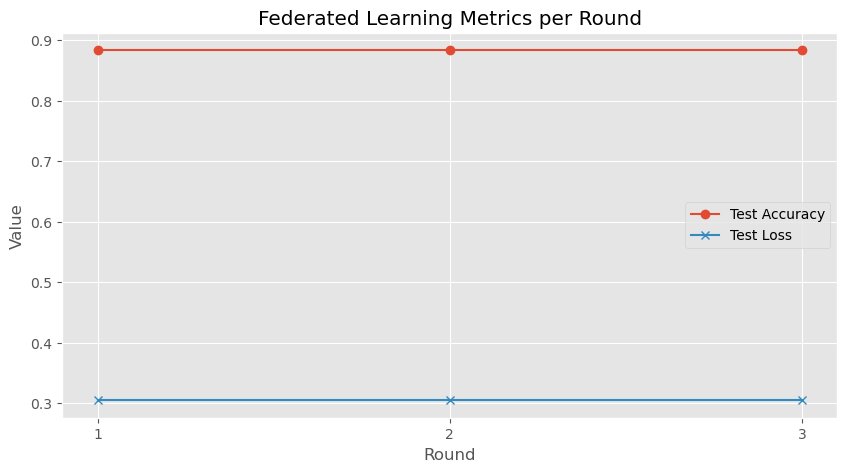

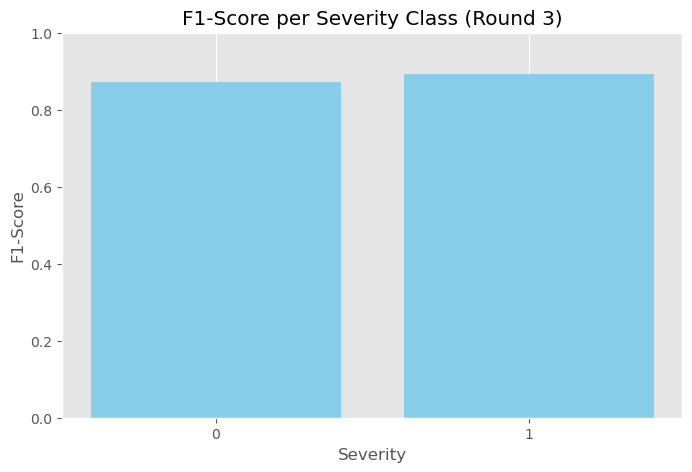

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Severity mapping for classes (replace with your actual mapping)
severity_mapping = {
    "Normal": 0,
    "Low": 1,
    "Medium": 2,
    "High": 3,
}

# Collect metrics for plotting
rounds = [m['round'] for m in test_metrics_history]
accuracy = [m['accuracy'] for m in test_metrics_history]
loss = [m['loss'] for m in test_metrics_history]

# Line Graph: Accuracy and Loss per round
plt.figure(figsize=(10, 5))
plt.plot(rounds, accuracy, marker='o', label='Test Accuracy')
plt.plot(rounds, loss, marker='x', label='Test Loss')
plt.title("Federated Learning Metrics per Round")
plt.xlabel("Round")
plt.ylabel("Value")
plt.xticks(rounds)
plt.legend()
plt.grid(True)
plt.show()

# Bar Graph: F1-score per severity class for last round
last_round_report = test_metrics_history[-1]['classification_report']
f1_scores = []
severity_labels = []

for cls, stats in last_round_report.items():
    if cls not in ["accuracy", "macro avg", "weighted avg"]:
        f1_scores.append(stats['f1-score'])
        severity_labels.append(cls)

# Sort by severity if needed
severity_idx = [severity_mapping.get(lbl, 0) for lbl in severity_labels]
f1_scores_sorted = [x for _, x in sorted(zip(severity_idx, f1_scores))]
severity_labels_sorted = [x for _, x in sorted(zip(severity_idx, severity_labels))]

plt.figure(figsize=(8, 5))
plt.bar(severity_labels_sorted, f1_scores_sorted, color='skyblue')
plt.title(f"F1-Score per Severity Class (Round {rounds[-1]})")
plt.xlabel("Severity")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()
